In [1]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from stochastic_dynamics.models import DeepLagEmbed, ARMLP, ARTransformer, AnalyticalAR
from stochastic_dynamics.generators import tvar
from stochastic_dynamics.utils import train_loop, bench_loop
from stochastic_dynamics.plottings import plot_history, plot_coefficients_by_p, plot_tvar_sample

from torchinfo import summary
from sklearn.model_selection import train_test_split


In [2]:
def split_dataset(npz_path, train_split=0.8, random_seed=42):
    
    data = np.load(npz_path)

    
    X = data["X"]              # [N, T]
    coeffs = data["A"]         # [N, T, p_max]
    p_true_raw = data["p_true"]  # [N], actual AR orders (e.g., 1, 2, 4, 6)
    
    # Convert p_true to 0-indexed labels for cross entropy loss
    unique_p = np.sort(np.unique(p_true_raw))
    p_to_idx = {int(p): i for i, p in enumerate(unique_p)}
    p_true = np.array([p_to_idx[int(p)] for p in p_true_raw], dtype=np.int64)
    
    # Stratified train/val split to maintain balanced p distribution
    indices = np.arange(len(X))
    train_idx, val_idx = train_test_split(
        indices, 
        train_size=train_split, 
        stratify=p_true,  # Ensures balanced p values in both splits
        random_state=random_seed
    )
    
    X_train, X_val = X[train_idx], X[val_idx]
    coeffs_train, coeffs_val = coeffs[train_idx], coeffs[val_idx]
    p_train, p_val = p_true[train_idx], p_true[val_idx]
    data.close()
    
    unique_p = np.sort(np.unique(p_true_raw))  # [2, 3, 4, 5, 6]
    p_to_idx = {int(p): i for i, p in enumerate(unique_p)}  # {2:0, 3:1, 4:2, 5:3, 6:4}
    p_true = np.array([p_to_idx[int(p)] for p in p_true_raw], dtype=np.int64)
    print(unique_p)
    print(p_to_idx)
    print(p_true)
    return X_train, coeffs_train, p_train, X_val, coeffs_val, p_val


In [3]:
# d = np.load('model/novak_data.npz')
# X_train, coef_train, \
#     p_train, X_val, coef_val, p_val = [d[k][:] for k in ['X_train', 'coef_train', 
#                                                       'p_train', 'X_val', 'coef_val', 'p_val']]
# d.close()

In [4]:
X_train, coeffs_train, p_train, X_val, coeffs_val, p_val = split_dataset('model/novak_data.npz')

[2 3 4 5 6]
{2: 0, 3: 1, 4: 2, 5: 3, 6: 4}
[1 4 3 ... 3 0 2]


In [5]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if device.type == 'cuda':
    torch.cuda.init()

# To tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
p_train = torch.tensor(p_train, dtype=torch.long)
X_val = torch.tensor(X_val, dtype=torch.float32)
p_val = torch.tensor(p_val, dtype=torch.long)
train_loader = DataLoader(TensorDataset(X_train, p_train), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, p_val), batch_size=32)

Using device: cuda:1


In [6]:
def do_bench_on_config(lambda_config):
    
    # hyperparameters
    n_epochs = 20
    lr = 1e-3
    max_ar_order = 6
    

    # Model: n_classes=5 for p∈{2,3,4,5,6}, max_ar_order=6 for coefficient dimensions
    # model = DeepLagEmbed(seq_len=600, n_classes=5, max_ar_order=6, hidden_dim=128)
    # model = DeepLagEmbed(seq_len=600, n_classes=5, max_ar_order=6, hidden_dim=128)
    # model = ARMLP(seq_len=600, n_classes=5, max_ar_order=6, hidden_dim=128)
    # model = ARTransformer(seq_len=600, n_classes=5, max_ar_order=6, d_model=64, nhead=4, num_layers=2)
    model = AnalyticalAR(seq_len=600, n_classes=5, max_ar_order=6)
    model = model.to(device)

    # summary(model, input_size=(32, 600), device=device)

    # Train
    history = train_loop(
        model, train_loader, val_loader,
        n_epochs=n_epochs, lr=lr,
        lambda_p=lambda_config["lambda_p"], 
        lambda_ar=lambda_config["lambda_ar"], 
        lambda_energy=lambda_config["lambda_energy"],
        lambda_smooth=lambda_config["lambda_smooth"], 
        lambda_order=lambda_config["lambda_order"],
        p_max=max_ar_order, device=device
    )
    return model, history

OLS Results:


Training: 100%|██████████| 20/20 [02:31<00:00,  7.57s/it, p_acc=0.200, train=0.6977, val=0.6971]


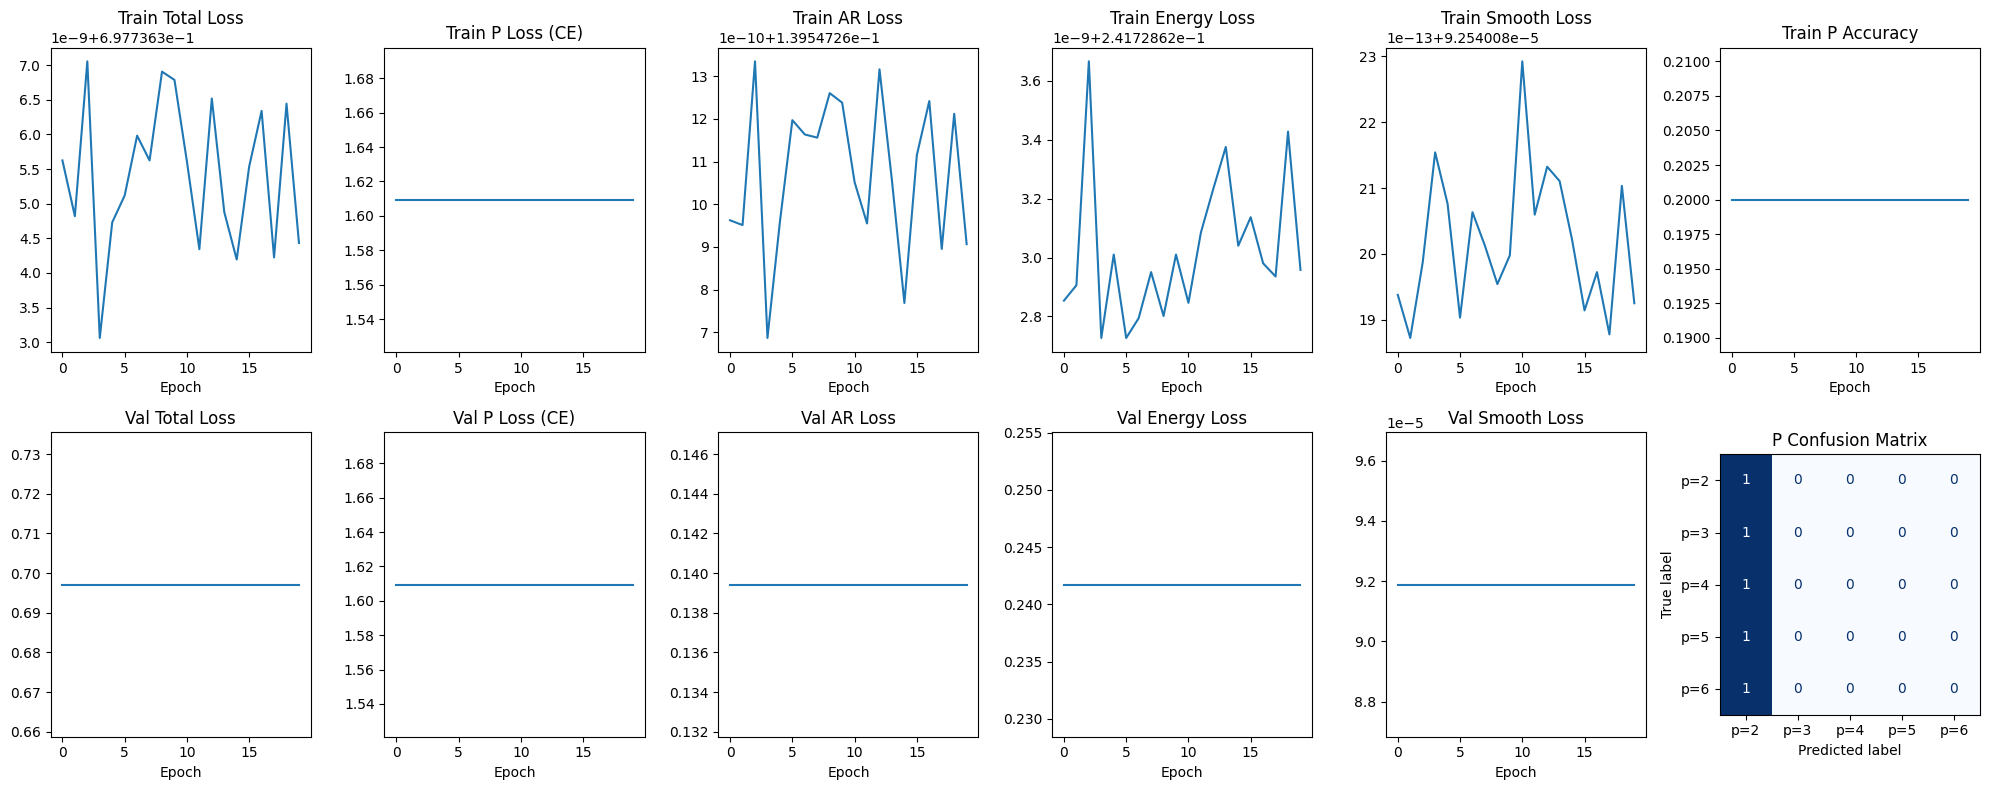

coeff_mse: 0.01577838510274887
signal_mse: 0.13942061364650726
p_mae: 2.0
p_mape: 0.42
p2_acc: 1.0
p3_acc: 0.0
p4_acc: 0.0
p5_acc: 0.0
p6_acc: 0.0
p_acc: 0.2


In [7]:
# embed_config = {
#     "lambda_ar": 5.0,
#     "lambda_p": 4.0,
#     "lambda_order": 0,
#     "lambda_energy": 0.1,
#     "lambda_smooth": 3
# }

config = {
    "lambda_ar": 5.0,
    "lambda_p": 0,
    "lambda_order": 0,
    "lambda_energy": 0,
    "lambda_smooth": 0
}

print("OLS Results:")
model, history = do_bench_on_config(config)
plot_history(history, model=model, val_loader=val_loader, device=device)
full_bench_results = bench_loop(model, X_val, coeffs_val[:, :, :6], p_val, device)
for k, v in full_bench_results.items():
    print(f"{k}: {v}")

In [8]:
def do_bench_on_config(lambda_config):
    
    # hyperparameters
    n_epochs = 20
    lr = 1e-3
    max_ar_order = 6
    

    # Model: n_classes=5 for p∈{2,3,4,5,6}, max_ar_order=6 for coefficient dimensions
    # model = DeepLagEmbed(seq_len=600, n_classes=5, max_ar_order=6, hidden_dim=128)
    # model = DeepLagEmbed(seq_len=600, n_classes=5, max_ar_order=6, hidden_dim=128)
    # model = ARMLP(seq_len=600, n_classes=5, max_ar_order=6, hidden_dim=128)
    model = ARTransformer(seq_len=600, n_classes=5, max_ar_order=6, d_model=64, nhead=4, num_layers=2)
    # model = AnalyticalAR(seq_len=600, n_classes=5, max_ar_order=6)
    model = model.to(device)

    # summary(model, input_size=(32, 600), device=device)

    # Train
    history = train_loop(
        model, train_loader, val_loader,
        n_epochs=n_epochs, lr=lr,
        lambda_p=lambda_config["lambda_p"], 
        lambda_ar=lambda_config["lambda_ar"], 
        lambda_energy=lambda_config["lambda_energy"],
        lambda_smooth=lambda_config["lambda_smooth"], 
        lambda_order=lambda_config["lambda_order"],
        p_max=max_ar_order, device=device
    )
    return model, history

Transformer Results:


Training: 100%|██████████| 20/20 [04:26<00:00, 13.33s/it, p_acc=0.200, train=0.0176, val=0.0579]


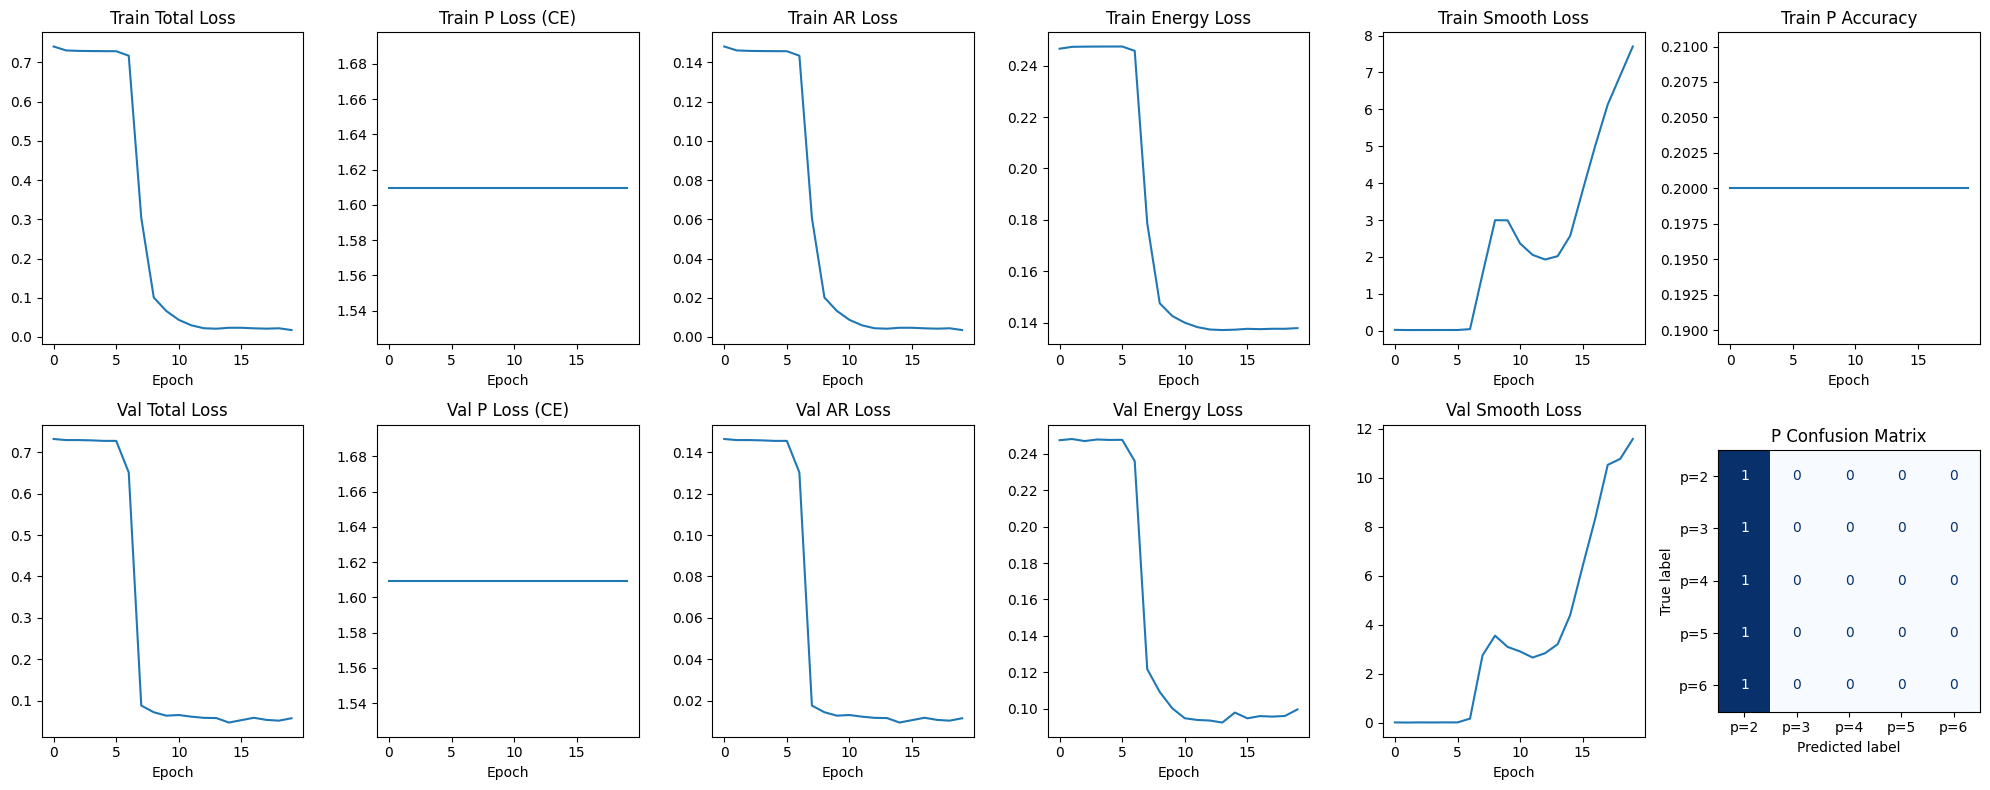

coeff_mse: 0.9800968170166016
signal_mse: 0.01157995406538248
p_mae: 2.0
p_mape: 0.42
p2_acc: 1.0
p3_acc: 0.0
p4_acc: 0.0
p5_acc: 0.0
p6_acc: 0.0
p_acc: 0.2


In [9]:
# embed_config = {
#     "lambda_ar": 5.0,
#     "lambda_p": 4.0,
#     "lambda_order": 0,
#     "lambda_energy": 0.1,
#     "lambda_smooth": 3
# }

config = {
    "lambda_ar": 5.0,
    "lambda_p": 0,
    "lambda_order": 0,
    "lambda_energy": 0,
    "lambda_smooth": 0
}

print("Transformer Results:")
model, history = do_bench_on_config(config)
plot_history(history, model=model, val_loader=val_loader, device=device)
full_bench_results = bench_loop(model, X_val, coeffs_val[:, :, :6], p_val, device)
for k, v in full_bench_results.items():
    print(f"{k}: {v}")

In [10]:
def do_bench_on_config(lambda_config):
    
    # hyperparameters
    n_epochs = 20
    lr = 1e-3
    max_ar_order = 6
    

    # Model: n_classes=5 for p∈{2,3,4,5,6}, max_ar_order=6 for coefficient dimensions
    # model = DeepLagEmbed(seq_len=600, n_classes=5, max_ar_order=6, hidden_dim=128)
    # model = DeepLagEmbed(seq_len=600, n_classes=5, max_ar_order=6, hidden_dim=128)
    model = ARMLP(seq_len=600, n_classes=5, max_ar_order=6, hidden_dim=128)
    # model = ARTransformer(seq_len=600, n_classes=5, max_ar_order=6, d_model=64, nhead=4, num_layers=2)
    # model = AnalyticalAR(seq_len=600, n_classes=5, max_ar_order=6)
    model = model.to(device)

    # summary(model, input_size=(32, 600), device=device)

    # Train
    history = train_loop(
        model, train_loader, val_loader,
        n_epochs=n_epochs, lr=lr,
        lambda_p=lambda_config["lambda_p"], 
        lambda_ar=lambda_config["lambda_ar"], 
        lambda_energy=lambda_config["lambda_energy"],
        lambda_smooth=lambda_config["lambda_smooth"], 
        lambda_order=lambda_config["lambda_order"],
        p_max=max_ar_order, device=device
    )
    return model, history

MLP Results:


Training: 100%|██████████| 20/20 [00:59<00:00,  2.95s/it, p_acc=0.200, train=0.7155, val=0.7300]


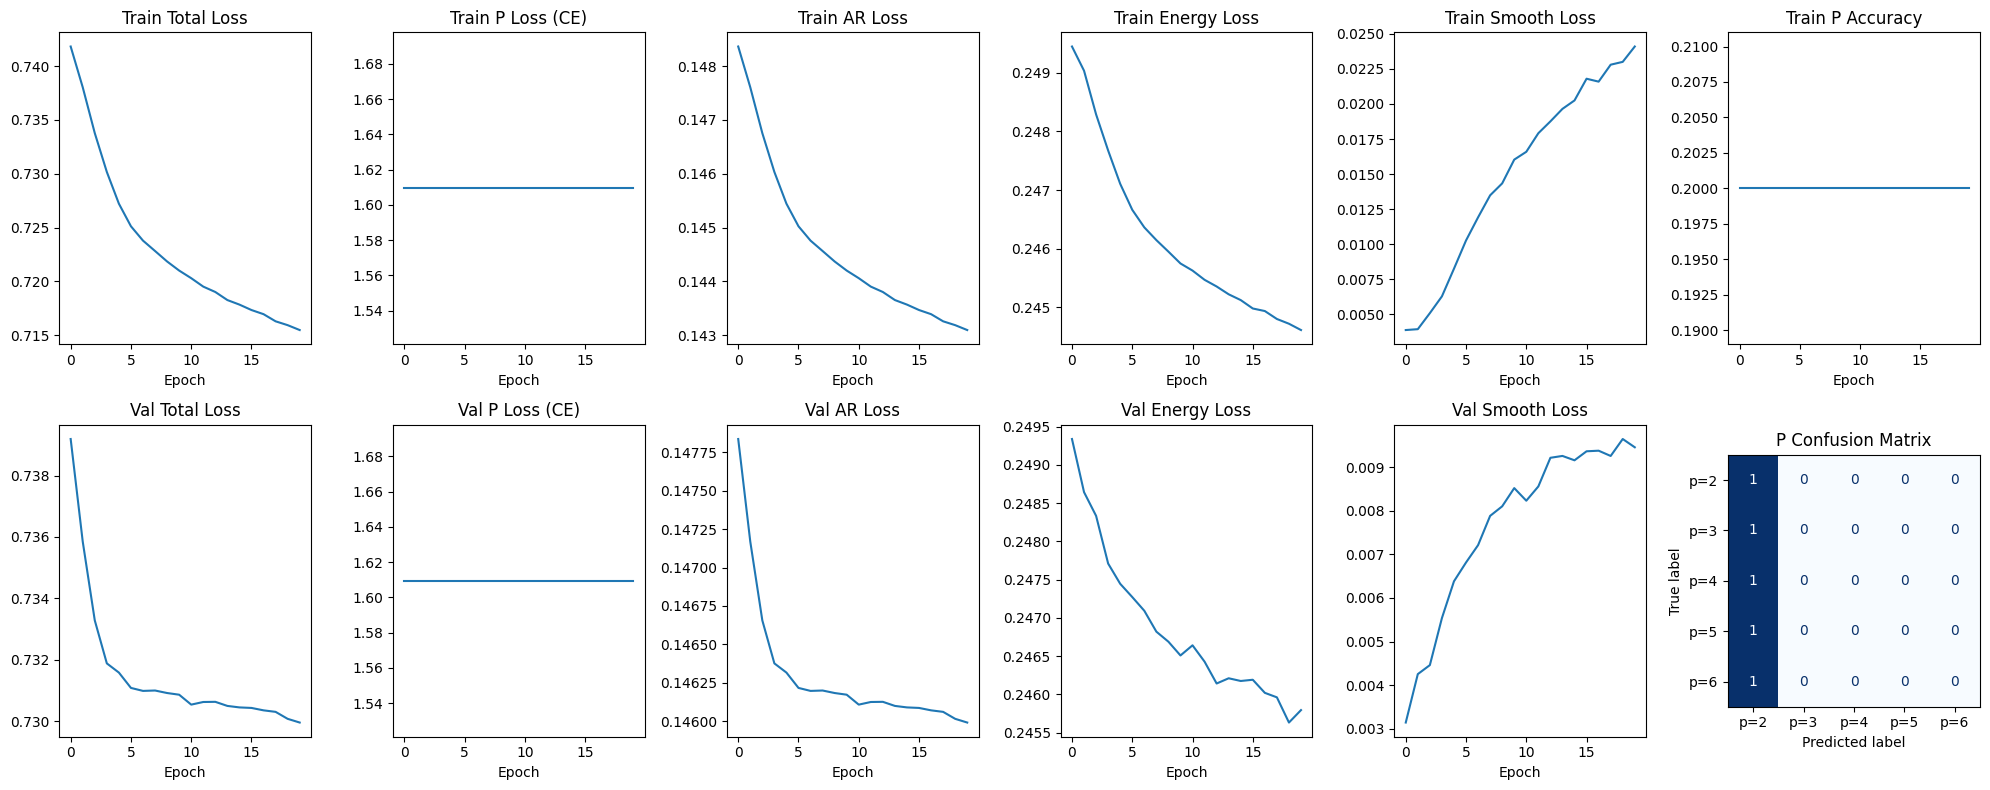

coeff_mse: 0.0185367614030838
signal_mse: 0.14599043130874634
p_mae: 2.0
p_mape: 0.42
p2_acc: 1.0
p3_acc: 0.0
p4_acc: 0.0
p5_acc: 0.0
p6_acc: 0.0
p_acc: 0.2


In [11]:
# embed_config = {
#     "lambda_ar": 5.0,
#     "lambda_p": 4.0,
#     "lambda_order": 0,
#     "lambda_energy": 0.1,
#     "lambda_smooth": 3
# }

config = {
    "lambda_ar": 5.0,
    "lambda_p": 0,
    "lambda_order": 0,
    "lambda_energy": 0,
    "lambda_smooth": 0
}

print("MLP Results:")
model, history = do_bench_on_config(config)
plot_history(history, model=model, val_loader=val_loader, device=device)
full_bench_results = bench_loop(model, X_val, coeffs_val[:, :, :6], p_val, device)
for k, v in full_bench_results.items():
    print(f"{k}: {v}")

In [12]:
def do_bench_on_config(lambda_config):
    
    # hyperparameters
    n_epochs = 20
    lr = 1e-3
    max_ar_order = 6
    

    # Model: n_classes=5 for p∈{2,3,4,5,6}, max_ar_order=6 for coefficient dimensions
    # model = DeepLagEmbed(seq_len=600, n_classes=5, max_ar_order=6, hidden_dim=128)
    model = DeepLagEmbed(seq_len=600, n_classes=5, max_ar_order=6, hidden_dim=128)
    # model = ARMLP(seq_len=600, n_classes=5, max_ar_order=6, hidden_dim=128)
    # model = ARTransformer(seq_len=600, n_classes=5, max_ar_order=6, d_model=64, nhead=4, num_layers=2)
    # model = AnalyticalAR(seq_len=600, n_classes=5, max_ar_order=6)
    model = model.to(device)

    # summary(model, input_size=(32, 600), device=device)

    # Train
    history = train_loop(
        model, train_loader, val_loader,
        n_epochs=n_epochs, lr=lr,
        lambda_p=lambda_config["lambda_p"], 
        lambda_ar=lambda_config["lambda_ar"], 
        lambda_energy=lambda_config["lambda_energy"],
        lambda_smooth=lambda_config["lambda_smooth"], 
        lambda_order=lambda_config["lambda_order"],
        p_max=max_ar_order, device=device
    )
    return model, history

DeepEmbed Results:


Training: 100%|██████████| 20/20 [01:20<00:00,  4.01s/it, p_acc=0.209, train=1.6044, val=24.8827]


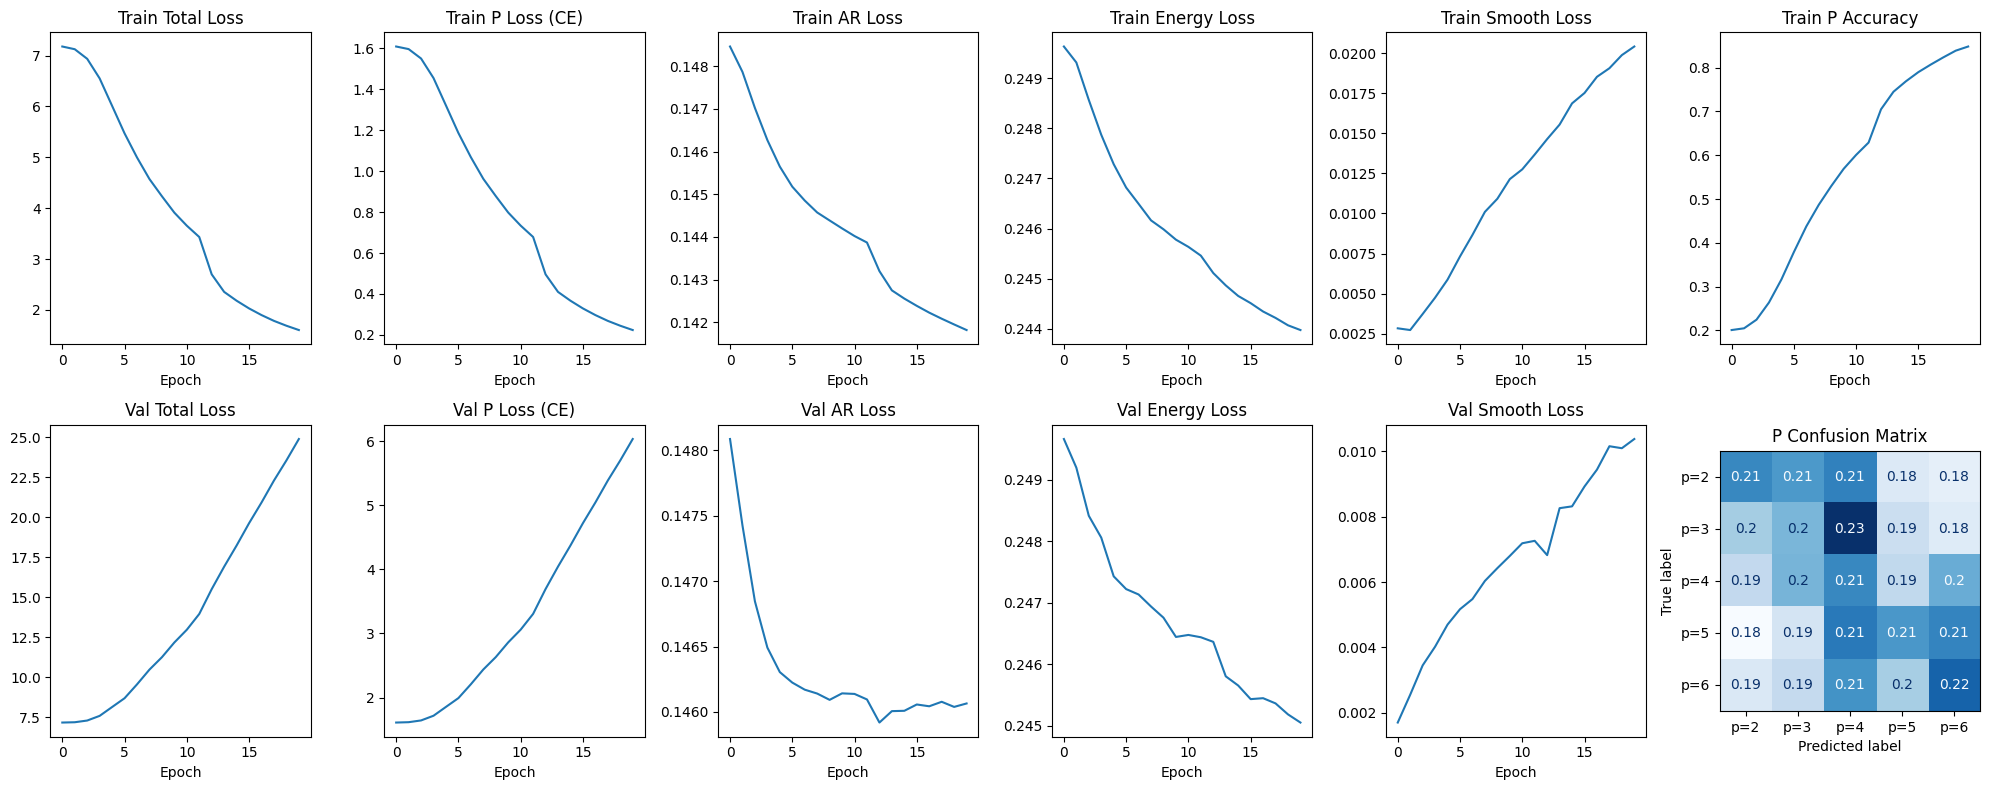

coeff_mse: 0.01875598542392254
signal_mse: 0.14606547355651855
p_mae: 1.5496875
p_mape: 0.46243124999999996
p2_acc: 0.20625
p3_acc: 0.2040625
p4_acc: 0.21125
p5_acc: 0.204375
p6_acc: 0.2171875
p_acc: 0.208625


In [13]:
# embed_config = {
#     "lambda_ar": 5.0,
#     "lambda_p": 4.0,
#     "lambda_order": 0,
#     "lambda_energy": 0.1,
#     "lambda_smooth": 3
# }

config = {
    "lambda_ar": 5.0,
    "lambda_p": 4.0,
    "lambda_order": 0,
    "lambda_energy": 0,
    "lambda_smooth": 0
}

print("DeepEmbed Results:")
model, history = do_bench_on_config(config)
plot_history(history, model=model, val_loader=val_loader, device=device)
full_bench_results = bench_loop(model, X_val, coeffs_val[:, :, :6], p_val, device)
for k, v in full_bench_results.items():
    print(f"{k}: {v}")

In [14]:
def do_bench_on_config(lambda_config):
    
    # hyperparameters
    n_epochs = 20
    lr = 1e-3
    max_ar_order = 6
    

    # Model: n_classes=5 for p∈{2,3,4,5,6}, max_ar_order=6 for coefficient dimensions
    model = DeepLagEmbed(seq_len=600, n_classes=5, max_ar_order=6, hidden_dim=128)
    # model = DeepLagEmbed(seq_len=600, n_classes=5, max_ar_order=6, hidden_dim=128)
    # model = ARMLP(seq_len=600, n_classes=5, max_ar_order=6, hidden_dim=128)
    # model = ARTransformer(seq_len=600, n_classes=5, max_ar_order=6, d_model=64, nhead=4, num_layers=2)
    # model = AnalyticalAR(seq_len=600, n_classes=5, max_ar_order=6)
    model = model.to(device)

    # summary(model, input_size=(32, 600), device=device)

    # Train
    history = train_loop(
        model, train_loader, val_loader,
        n_epochs=n_epochs, lr=lr,
        lambda_p=lambda_config["lambda_p"], 
        lambda_ar=lambda_config["lambda_ar"], 
        lambda_energy=lambda_config["lambda_energy"],
        lambda_smooth=lambda_config["lambda_smooth"], 
        lambda_order=lambda_config["lambda_order"],
        p_max=max_ar_order, device=device
    )
    return model, history

PINN Results:


Training: 100%|██████████| 20/20 [01:21<00:00,  4.06s/it, p_acc=0.206, train=1.6454, val=24.9410]


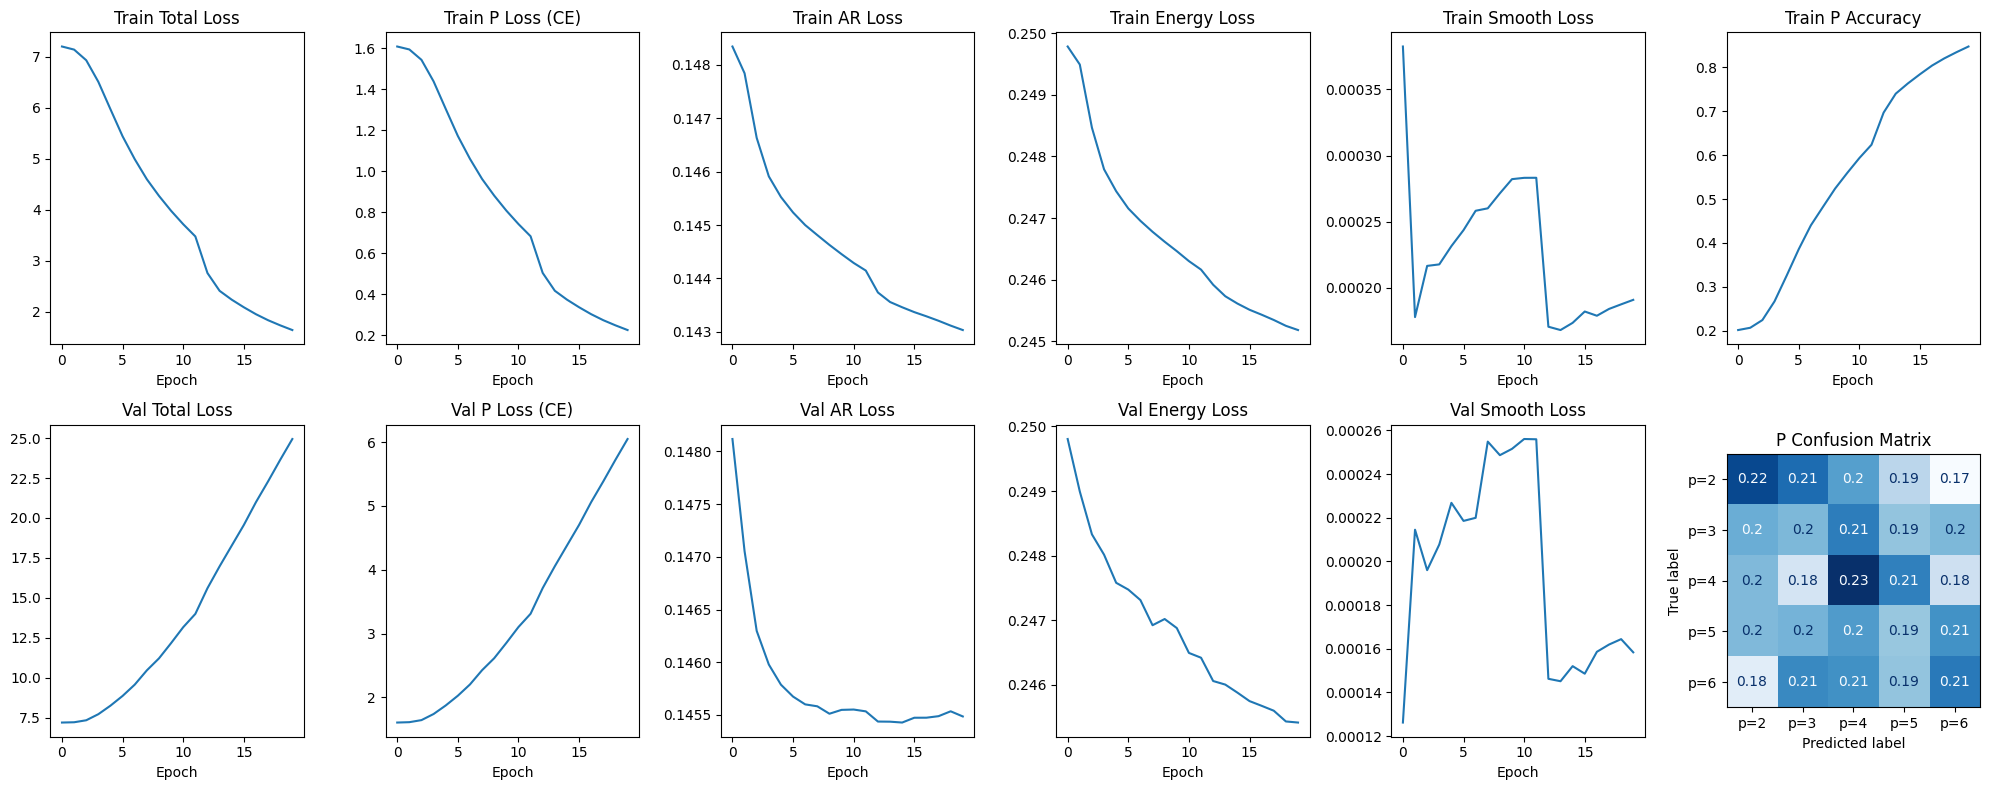

coeff_mse: 0.018038874492049217
signal_mse: 0.14548787474632263
p_mae: 1.564375
p_mape: 0.4625625
p2_acc: 0.215
p3_acc: 0.196875
p4_acc: 0.224375
p5_acc: 0.1903125
p6_acc: 0.2046875
p_acc: 0.20625


In [15]:
# embed_config = {
#     "lambda_ar": 5.0,
#     "lambda_p": 4.0,
#     "lambda_order": 0,
#     "lambda_energy": 0.1,
#     "lambda_smooth": 3
# }

config = {
    "lambda_ar": 5.0,
    "lambda_p": 4.0,
    "lambda_order": 0,
    "lambda_energy": 0.1,
    "lambda_smooth": 3
}

print("PINN Results:")
model, history = do_bench_on_config(config)
plot_history(history, model=model, val_loader=val_loader, device=device)
full_bench_results = bench_loop(model, X_val, coeffs_val[:, :, :6], p_val, device)
for k, v in full_bench_results.items():
    print(f"{k}: {v}")